# High Energy Photon Cooling

In this notebook, we demonstrate how the high energy photon cooling works and run some cross checks. 

## Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

## Load Reference Results

These reference results start with a delta-function like injection at a redshift of $(1+z) = 31$ of 2 photons at the energy given by the file name. The high energy photons are stored in `file_photonspectrum`, low energy photons in `file_lowengphot` and low energy electrons in `file_lowengelec`. The photon energy abscissa is `file_eng` (both high and low) while the electron energy abscissa is `file_eleceng`. 

In [3]:
eng_ind = 99

# Check that this matches with the input 

file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_eleceng = file[1].data['eleceng'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]
file_lowengphot = file[1].data['lowengphot'][0,:,:]
file_lowengelec = file[1].data['lowengelec'][0,:,:]

Turn the data into `Spectra` objects. 

In [4]:
file_highengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_lowengphot_spectra = Spectra([Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_lowengphot, file_rs)])

file_lowengelec_spectra = Spectra([Spectrum(file_eleceng, elecspec, rs=rs) 
                   for elecspec,rs in zip(file_lowengelec, file_rs)])

## Photon Cooling

Now we cool the photons that result from the high energy photon injection. Photons below 3.1 keV are considered low energy photons. For high energy photons, greater than 3.1 keV, we have transfer functions into high energy photons, low energy photons and low energy electrons. Let's load them first.

In [5]:
user = 'hongwan'

highengphot_tflist = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))
lowengphot_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec.raw", "rb"))
lowengelec_tflist  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec.raw", "rb"))


The data is saved as a `TransferFuncList` class. This is essentially a list of transfer functions. There are two types, and the type is stored as `TransferFuncList.tftype`. If `tftype` is `'rs'`, then the `TransferFuncList` is a collection of transfer functions at each redshift (the transfer functions are stored as a class called `TransFuncAtRedshift`). Each transfer function is a series of spectra with some injection energy, and some output spectrum. The redshift, injection energy and spectrum abscissa can be checked with `TransferFuncList.rs`, `TransferFuncList.in_eng` and `TransferFuncList.eng` respectively. The other `tftype` is `'in_eng'`, which is a collection of transfer functions at fixed injection energy (the class is called `TransFuncAtEnergy`), and stores the spectra that results from a delta-function injection at this injection energy at a series of redshifts. 

To switch between types, use `TransferFuncList.transpose()`. Currently, `highengphot_tflist`, `lowengphot_tflist` and `lowengelec_tflist` are stored as type `'in_eng'`. We take the transpose to change to type `'rs'`, and do some numerical clean up. 

In [6]:
# Changes all of the tflists to TransFuncAtRedshift
highengphot_tflist.transpose()
lowengphot_tflist.transpose()
lowengelec_tflist.transpose()

# This is a list of mwimp values used to generate highengphot_tflist
mwimp_arr = np.array(highengphot_tflist.in_eng)

# This shouldn't be necessary. There is one negative value somewhere. Check.
for tf in highengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100
for tf in lowengphot_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100
for tf in lowengelec_tflist:
    tf.grid_vals[np.where(tf.grid_vals < 0)] = 1e-100

## Inputs

Next, we define the input spectrum. Currently, `eleceng` and `photeng` must be defined as follows for accuracy, although `n` can be adjusted for speed. Here, we define a delta-function like injection at `mwimp_arr[eng_ind]`, which will correspond exactly with the reference file chosen. Note that `spectools.rebin_N_arr` produces a `Spectrum` object of type `'dNdE'` by default, so `Spectrum.switch_spec_type()` is required, since all of the transfer functions evolve `Spectrum` objects of type `'N'`. 

In [7]:
n = 3

eleceng = lowengelec_tflist.eng
photeng = highengphot_tflist.in_eng
step = np.log(photeng[1]) - np.log(photeng[0])
test = np.exp(np.arange(np.log(photeng[0]), np.log(9.9e-5), -step))
photeng = np.append(np.flipud(test[1:]), photeng)

# eleceng = eleceng[1::n]
photeng = photeng[1::n]

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([mwimp_arr[eng_ind]]),
                                      photeng)
phot_spec_init.switch_spec_type()

To evolve the spectrum and allow for easy processing later, the high energy photon transfer function must be square. We make the abscissa for the transfer function `photeng` by `photeng` (injected energy by output energy), and simply pad the additional rows needed with zeros. For convenience, we also use `photeng` by `photeng` for the low energy photon transfer function, and `photeng` by `eleceng` for the low energy electron transfer function. The definitions for high and low energies are listed below. 

In [8]:
#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 3070]
photeng_low  = photeng[photeng <= 3070]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3500]
eleceng_low  = eleceng[eleceng <= 3500]


highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

for tf in highengphot_tflist:
    tf.rebin(photeng_high)
    
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (photeng_low.size, 0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
    tf._rs = tf.rs[0]*np.ones_like(photeng)
    
highengphot_tflist.eng = photeng
highengphot_tflist.in_eng = photeng
    
# lowengphot_tflist.in_eng set to photeng_high
lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengphot_tflist:
    tf.rebin(photeng)
    # Pad with zeros so that it becomes photeng x photeng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = photeng
    tf._rs = tf.rs[0]*np.ones_like(photeng)
lowengphot_tflist.eng = photeng
lowengphot_tflist.in_eng = photeng
    
# lowengelec_tflist.in_eng set to photeng_high 
lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
for tf in lowengelec_tflist:
    tf.rebin(eleceng)
    # Pad with zeros so that it becomes photeng x eleceng. 
    tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
    tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
    tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
    tf._in_eng = photeng
    tf._eng = eleceng
    tf._rs = tf.rs[0]*np.ones_like(photeng)

lowengelec_tflist.eng = eleceng
lowengelec_tflist.in_eng = photeng

../darkhistory/spec/spectra.py:852: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


## Coarsening

We need to decide on the redshift step to use. The default redshift step in the transfer functions is $d \log (1+z) = 0.002$, with the transfer function with this step size evaluated at (currently) 50 redshifts, from $z = 30$ to $z = 4$. If we stick with this step size, then we must interpolate the transfer function at 2049 points between $z = 30$ and $z = 4$, so that every multiplication by the transfer function advances the spectrum by a step of $d \log (1+z) = 0.002$. 

However, we can coarsen the high energy photon transfer function by some factor $f$ by multiplying the transfer function matrix by itself multiple times, producing transfer functions for a redshift step of $d \log (1+z) = f \times 0.002$. The assumption here is that the transfer function does not change significantly over this bigger redshift step, which appears to be a good approximation in all of the cases checked so far. We will then have to interpolate the transfer function at $2049/f$ steps, and perform $2049/f$ matrix multiplications to evolve the spectrum from $z=30$ to $z=4$. 

This is performed using the function `TransferFuncList.coarsen()`. There are two types of coarsening: one is for a propagation matrix, where we simply multiply the transfer function by itself multiple times (here given by `coarsen_factor`). The other is for a deposition matrix. The deposition matrix is taken to be constant over the number of steps given by `coarsen_factor`, and is applied to the high energy photon spectrum that is produced by each multiplication of the transfer function to get to the next redshift. After coarsening, if the propagation transfer function is $P$, and the deposition transfer function is $D$, coarsening returns $B (1 + P + \cdots + P^{n-1})$. 

After coarsening, the resulting transfer functions are then interpolated at the redshifts given in `rs_list`. 

In [9]:
# The redshift step to use will be coarsen_factor * 0.002
coarsen_factor = 5
# Generate the redshifts at which we want to get an interpolated value for the transfer function. 
tf_rs_arr = highengphot_tflist.rs
rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -highengphot_tflist.dlnz*coarsen_factor)
                )

if coarsen_factor > 1:
    lowengphot_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    lowengelec_tflist.coarsen(coarsen_factor, delete_tfs=False, coarsen_type='dep', prop_transfunclist=highengphot_tflist)
    highengphot_tflist.coarsen(coarsen_factor, delete_tfs=False)
    
lowengphot_tflist.at_val('rs',rs_list)
lowengelec_tflist.at_val('rs',rs_list)
highengphot_tflist.at_val('rs',rs_list)

phot_spec_init.rs = rs_list[0]

## Evolution with Redshift

Now we evolve the initial photon spectrum across all of the redshifts specified in `rs_list`, using the coarsened transfer functions. This is performed by calling the function `spectools.evolve()`, which takes as arguments the initial spectrum, the list of propagation transfer functions, as well as a list of deposition transfer functions. We want to use `evolve_type='prop'` for the high energy photons (just propagation) and `evolve_type='dep'` for low energy electrons and photons, in which case we must specify both propagation and deposition transfer matrices. `save_steps` determines whether the output is a single `Spectrum` at the end of the whole propagation, or a `Spectra` object, which records the spectrum at each intermediate step.

In [10]:
highengphot_spectra = spectools.evolve(phot_spec_init, highengphot_tflist, evolve_type='prop', save_steps=True)

In [11]:
lowengphot_spectra  = spectools.evolve(
    phot_spec_init, lowengphot_tflist,  
    evolve_type='dep',  prop_tflist=highengphot_tflist, save_steps=True
)

In [12]:
lowengelec_spectra = spectools.evolve(
    phot_spec_init, lowengelec_tflist,
    evolve_type='dep', prop_tflist=highengphot_tflist, save_steps=True
)

## Processing the Inputs for Comparison

Here, we process the data from our reference files in order to make the comparison with our result. First, we need to rebin the reference file spectra into the same energy abscissa as our output from above. Then, we switch the spectrum to `'N'` type, so that we can make a direct comparison by plotting `Spectrum.N`. 

In [13]:
file_highengphot_spectra.rebin(highengphot_spectra.eng)
file_highengphot_spectra.switch_spec_type()
file_lowengphot_spectra.rebin(lowengphot_spectra.eng)
file_lowengphot_spectra.switch_spec_type()
file_lowengelec_spectra.rebin(lowengelec_spectra.eng)
file_lowengelec_spectra.switch_spec_type()

Because we have coarsened our deposition transfer function, the output in `lowengphot_spectra` and `lowengelec_spectra` is actually equivalent to the total deposition from a number of steps given by `coarsen_factor` in the original file. We have to add up all of the deposited low energy electrons and photons in the reference file in order to make the correct comparison.

In [14]:
combined_file_lowengphot_spectra = Spectra([], spec_type='N')
combined_file_lowengelec_spectra = Spectra([], spec_type='N')

for i in np.arange(np.floor_divide(2049,coarsen_factor)):
    mask = np.zeros(2049)
    mask[coarsen_factor*i:coarsen_factor*i+coarsen_factor] = 1
    out_spec_phot = file_lowengphot_spectra.sum_specs(mask)
    out_spec_elec = file_lowengelec_spectra.sum_specs(mask)
    out_spec_phot.rs = file_lowengphot_spectra[coarsen_factor*i].rs
    out_spec_elec.rs = file_lowengelec_spectra[coarsen_factor*i].rs
    combined_file_lowengphot_spectra.append(out_spec_phot)
    combined_file_lowengelec_spectra.append(out_spec_elec)
    


## Plots

[100.0, 10000000000000.0, 1e-12, 1000.0]

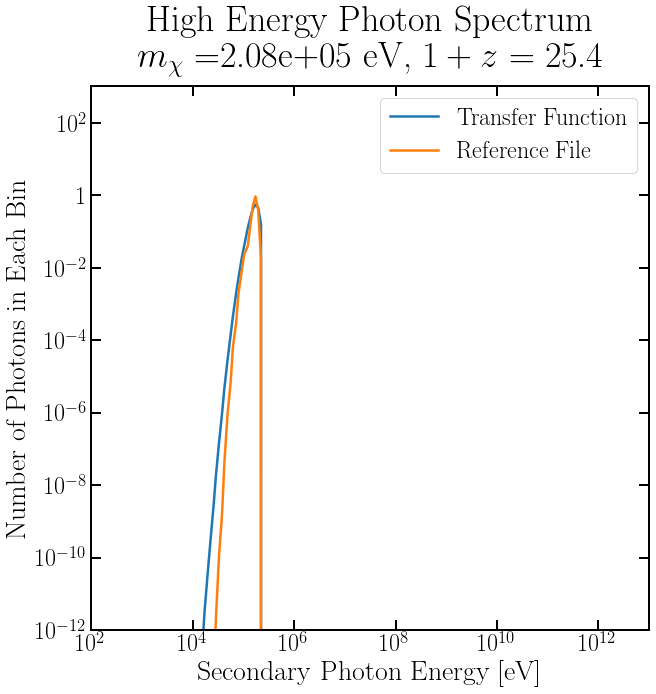

In [15]:
plt.figure()

i_plot = 20

ax = plt.gca()
tf_plot, = highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_plot, = file_highengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')


plt.title('High Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e2, 1e13, 1e-12, 1e3])

[0.0001, 4000000000000.0, 1e-20, 1000000.0]

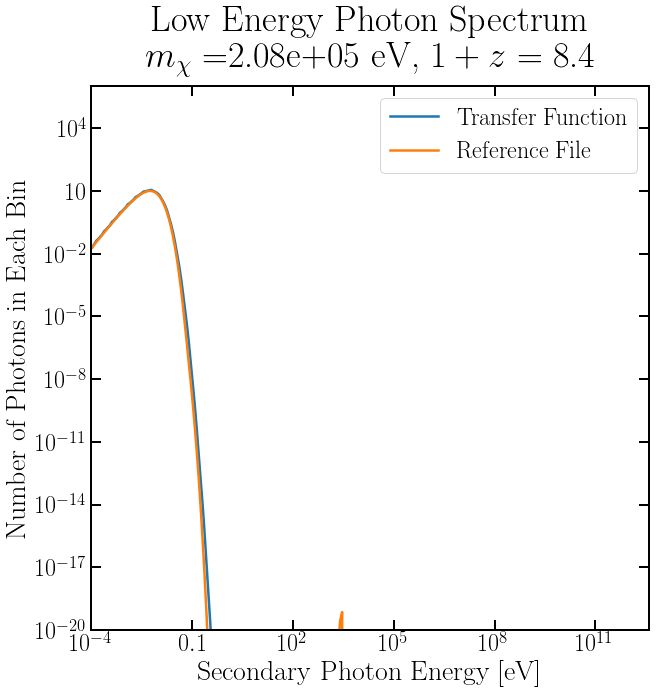

In [16]:
plt.figure()

i_plot = 130

ax = plt.gca()
tf_plot, = lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_plot, = combined_file_lowengphot_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')

plt.title('Low Energy Photon Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))


plt.xlabel('Secondary Photon Energy [eV]')
plt.ylabel('Number of Photons in Each Bin')
plt.axis([1e-4, 4e12, 1e-20, 1e6])

[0.1, 10000.0, 1e-07, 10]

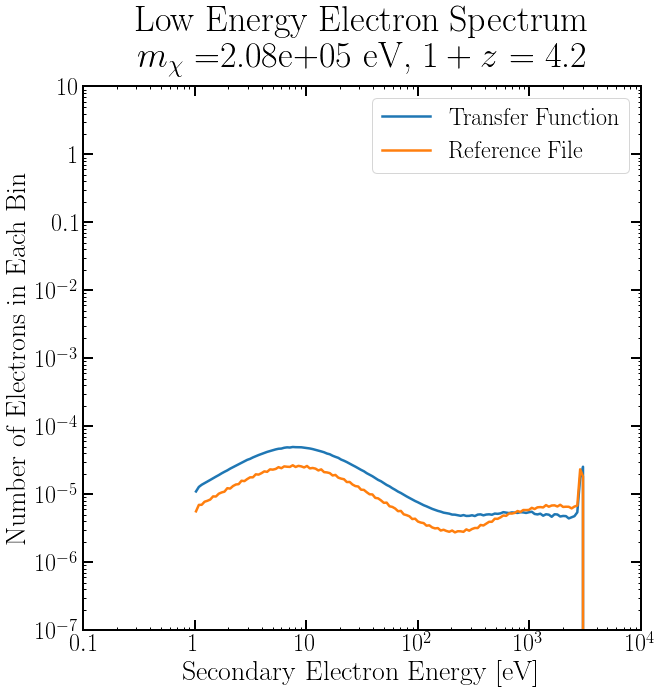

In [19]:
plt.figure()

i_plot = 199

ax = plt.gca()
tf_plot, = lowengelec_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=rs_list[i_plot], indtype='rs')
# tf_plot, = lowengelec_spectra.plot(ax, ind=rs_list[1], indtype='rs')
# file_plot, = combined_file_lowengelec_spectra.plot(ax, ind=rs_list[1], indtype='rs')

ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Low Energy Electron Spectrum\n' + r'$m_\chi$ ='
          +'{:.2e}'.format(mwimp_arr[eng_ind])
          +r' eV, $1+z$ = '+'{0:.1f}'.format(rs_list[i_plot])
         )

ax.legend((tf_plot, file_plot), ('Transfer Function', 'Reference File'))

plt.xlabel('Secondary Electron Energy [eV]')
plt.ylabel('Number of Electrons in Each Bin')
plt.axis([1e-1, 1e4, 1e-7, 10])

In [18]:
utils.compare_arr([lowengelec_spectra.grid_vals[0,:], lowengelec_spectra.grid_vals[199,:], 
                  combined_file_lowengelec_spectra.grid_vals[0,:], combined_file_lowengelec_spectra.grid_vals[199,:]])

[[9.22360735e-03 1.09618039e-05 7.67519305e-03 5.62187749e-04]
 [1.14442263e-02 1.27743077e-05 9.54413727e-03 6.99081179e-04]
 [1.14942325e-02 1.37517507e-05 9.58023814e-03 7.01723223e-04]
 [1.27927043e-02 1.45134252e-05 1.06221379e-02 7.78036392e-04]
 [1.31200991e-02 1.53072975e-05 1.09696259e-02 8.03485432e-04]
 [1.38139505e-02 1.61953856e-05 1.14390929e-02 8.37868387e-04]
 [1.51765118e-02 1.71481636e-05 1.27203900e-02 9.31713435e-04]
 [1.52165587e-02 1.81082375e-05 1.26757506e-02 9.28438306e-04]
 [1.68442183e-02 1.90890110e-05 1.39368699e-02 1.02080254e-03]
 [1.73285440e-02 2.02432034e-05 1.45437950e-02 1.06524859e-03]
 [1.82465235e-02 2.13407768e-05 1.49404847e-02 1.09429473e-03]
 [1.96957492e-02 2.23916136e-05 1.67828731e-02 1.22922599e-03]
 [2.00837261e-02 2.37359781e-05 1.65819438e-02 1.21449619e-03]
 [2.17970541e-02 2.49413793e-05 1.80541609e-02 1.32230862e-03]
 [2.26127258e-02 2.61914639e-05 1.90095232e-02 1.39226141e-03]
 [2.37105606e-02 2.76044720e-05 1.92753993e-02 1.411712

0